# Testing NLP Models and Front-End Display

In [1]:
import pandas as pd
import numpy as np
import gensim.downloader
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import collections
import requests
from PIL import Image
from io import BytesIO
from urllib.request import urlopen
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [36]:
# pd.set_option('display.max_colwidth', None)

# Load DF as pickle file

In [59]:
df = pd.read_pickle("../../data/test_data/kaggle_recipes/r_cleaned_recipes_3.pkl")


In [69]:
df.head(1)

,Name,RecipeCategory,Calories,images,cook_time,prep_time,total_time,recipe_servings,tags,instructions,ingredient_quantities,ingredients,ingredients_cleaned,ingred_and_tags,name_cat_ingred_tag,cat_ingred_tag
0,Low-Fat Berry Blue Frozen Dessert,Frozen Desserts,170.9,"[https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/yueirxmlqaee1h3v3qnm_229%20berry%20blue%20frzn%20dess.jpg, https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/afpddhatwzq0b1cdpdat_255%20berry%20blue%20frzn%20dess.jpg, https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/uygf9nwmt2sggjcuzilo_228%20berry%20blue%20frzn%20dess.jpg, https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/pebmjn2tgsayks2759ba_20140722_202142.jpg, https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/picuaeten.jpg, https://img.sndimg.com/food/image/upload/w_555,h_416,c_fit,fl_progressive,q_95/v1/img/recipes/38/pictzvxw5.jpg]",24 Hour(s),45 Minute(s),24 Hour(s) 45 Minute(s),4,"[dessert, low protein, low cholesterol, healthy, free of..., summer, weeknight, freezer, easy]","[Toss 2 cups berries with sugar., Let stand for 45 minutes., Stirring occasionally., Transfer berry-sugar mixture to food processor., Add yogurt and process until smooth., Strain through fine sieve. pour into baking pan (or transfer to ice cream maker and process according to manufacturers' directions). freeze uncovered until edges are solid but centre is soft. transfer to processor and blend until smooth again., Return to pan and freeze until edges are solid., Transfer to processor and blend until smooth again., Fold in remaining 2 cups of blueberries., Pour into plastic mold and freeze overnight. let soften slightly to serve.]","[4, 1/4, 1, 1]","[blueberries, granulated sugar, vanilla yogurt, lemon juice]","[blueberry, yogurt, lemon juice]","[blueberry, yogurt, lemon juice, dessert, low protein, low cholesterol, healthy, free of..., summer, weeknight, freezer, easy]","[Low-Fat, Berry, Blue, Frozen, Dessert, Frozen, Desserts, blueberry, yogurt, lemon juice, dessert, low protein, low cholesterol, healthy, free of..., summer, weeknight, freezer, easy]","[Frozen, Desserts, blueberry, yogurt, lemon juice, dessert, low protein, low cholesterol, healthy, free of..., summer, weeknight, freezer, easy]"


# Setting inputs of ingredients and preference

In [112]:
input_ingred = "chicken, potato, carrot"
input_tags = "easy, healthy"

# Test 1 - combining two NLP models with different weights

## Load models

In [38]:
model_i = Doc2Vec.load("nlp_models/r_ingred_d2v.model") #vector_size = 50, epochs = 100
model_t = Doc2Vec.load("nlp_models/r_tags_d2v.model") #vector_size 50, epochs = 100

FileNotFoundError: [Errno 2] No such file or directory: 'nlp_models/r_ingred_d2v.model'

In [ ]:
#----checking similarities for ingredients

tokens_ingred = input_ingred.split(", ")
new_vector_ingred = model_i.infer_vector(tokens_ingred)
most_similar_ingred = model_i.dv.most_similar([new_vector_ingred], topn= 100) # 1000 as ingredients are more important
# print(most_similar_ingred)
most_similar_ingred_list = [x[0] for x in most_similar_ingred]
most_similar_ingred_score = [x[0] for x in most_similar_ingred]

#----checking similarities for tags
tokens_tags= input_tags.split(", ")
new_vector_tags = model_t.infer_vector(tokens_tags)
most_similar_tags = model_t.dv.most_similar([new_vector_tags], topn= 10000)
# print(most_similar_tags)
most_similar_tags_list = [x[0] for x in most_similar_tags]
most_similar_tags_list = [x[1] for x in most_similar_tags]


## Listing top recipes indices by most similar ingredients and tags according to cosine similarity scores

In [39]:
ms_ingred_vector = pd.DataFrame(most_similar_ingred, columns=["index", "ingred_score"])
ms_tags_vector = pd.DataFrame(most_similar_tags, columns=["index", "tags_score"])
# ms_ingred_vector
# ms_tags_vector

## Set weights for ingredients and tags

In [40]:
ingred_weight = 5
tags_weight = 2

## Return top 5 recipes indices after applying weights and combining scores

In [41]:
merged = ms_ingred_vector.merge(ms_tags_vector, how = "left", on = "index")
merged['combined_score'] = merged['ingred_score']*ingred_weight + merged['tags_score']*tags_weight
merged_combined = merged.sort_values('combined_score', ascending=False)
# print(merged_combined['index'][:5])

merged_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 12 to 99
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           100 non-null    int64  
 1   ingred_score    100 non-null    float64
 2   tags_score      3 non-null      float64
 3   combined_score  3 non-null      float64
dtypes: float64(3), int64(1)
memory usage: 3.9 KB


In [42]:
merged_combined.head(5)

,index,ingred_score,tags_score,combined_score
12,165133,0.813623,0.842723,5.753561
30,397280,0.775244,0.711402,5.299025
83,1646,0.726734,0.762440,5.158552
0,287428,0.870006,NaN,NaN
1,408461,0.866503,NaN,NaN


## Returning Top 5 recipes in DF

In [43]:
recipe_dict = {}
for i in merged_combined['index']:
    recipe_dict[i] = df.iloc[i].to_dict()

most_similar_df = pd.DataFrame(recipe_dict).T.reset_index()
most_similar_df.head(5)[['index', 'Name', 'tags', 'ingredients', 'ingredients_cleaned']]

,index,Name,tags,ingredients,ingredients_cleaned
0,165133,Eggs in Their Nest,"[healthy, < 60 mins, easy]","[eggs, spinach, potatoes]","[egg, spinach, potato]"
1,397280,Potato Bowl,"[low cholesterol, healthy, < 60 mins]","[potatoes, bacon, leeks, garlic cloves, fresh spinach]","[potato, bacon, leek, garlic, spinach]"
2,1646,Chicken and Spinach Veloute,"[low cholesterol, healthy, < 15 mins, easy]","[spinach, heavy cream]",[spinach]
3,287428,Spinach and Potato Soup,"[vegetable, low protein, low cholesterol, healthy, < 30 mins, easy, inexpensive]","[potatoes, frozen spinach, sour cream]","[potato, spinach]"
4,408461,Stampot (Spinazie)- Dutch Potatoes and Spinach,"[potato, greens, vegetable, dutch, european, low protein, low cholesterol, healthy, < 30 mins, easy]","[potatoes, spinach, butter]","[potato, spinach]"


# Test 2 - one NLP model with ingred and tags combined

In [71]:
# # vector_size = 50, epochs = 100
# model_b = Doc2Vec.load("nlp_models/r_ingredtag_d2v.model")
# vector_size = 100, epochs = 100 --> better
model_b2 = Doc2Vec.load("../../nlp_models/nlp_model_ingred_tag_d2v_2.model")

model_ingred_tag = model_b2

In [72]:
combined_input = input_ingred + ", " + input_tags
tokens = [word.strip() for word in combined_input.split(",")]

vectors = model_ingred_tag.infer_vector(tokens)
most_similar_ = model_ingred_tag.dv.most_similar([vectors], topn = 5)
# print(most_similar_)
most_similar_list = [x[0] for x in most_similar_]
most_similar_score = [x[1] for x in most_similar_]

combined_dict = {}
for i in most_similar_list:
    combined_dict[i] = df.iloc[i].to_dict()

most_similar_df_b = pd.DataFrame(combined_dict).T.reset_index()
most_similar_df_b[['index', 'Name', 'tags', 'ingredients_cleaned', 'ingred_and_tags']]

,index,Name,tags,ingredients_cleaned,ingred_and_tags
0,165133,Eggs in Their Nest,"[healthy, < 60 mins, easy]","[egg, spinach, potato]","[egg, spinach, potato, healthy, < 60 mins, easy]"
1,287428,Spinach and Potato Soup,"[vegetable, low protein, low cholesterol, healthy, < 30 mins, easy, inexpensive]","[potato, spinach]","[potato, spinach, vegetable, low protein, low cholesterol, healthy, < 30 mins, easy, inexpensive]"
2,91952,Spinach and Bacon Baked Potatoes,"[pork, potato, vegetable, meat, low cholesterol, healthy, kid friendly, savory, oven, < 4 hours, inexpensive]","[potato, bacon, spinach, green, parmesan cheese]","[potato, bacon, spinach, green, parmesan cheese, pork, potato, vegetable, meat, low cholesterol, healthy, kid friendly, savory, oven, < 4 hours, inexpensive]"
3,408461,Stampot (Spinazie)- Dutch Potatoes and Spinach,"[potato, greens, vegetable, dutch, european, low protein, low cholesterol, healthy, < 30 mins, easy]","[potato, spinach]","[potato, spinach, potato, greens, vegetable, dutch, european, low protein, low cholesterol, healthy, < 30 mins, easy]"
4,60116,Mashed Potato Casserole,"[vegetable, healthy, < 30 mins, oven, easy]","[potato, spinach, cheese]","[potato, spinach, cheese, vegetable, healthy, < 30 mins, oven, easy]"


# Test 3 - one NLP model with ingredients, tags, categories combined

In [113]:
#vector_size = 100, epochs = 100 --> better
model_cit_1 = Doc2Vec.load("../../nlp_models/nlp_model_cit.model") 
model_cit = model_cit_1

In [114]:
cit_input = input_ingred + ", " + input_tags
cit_tokens = [word.strip() for word in cit_input.split(",")]

cit_vectors = model_cit.infer_vector(cit_tokens)

most_similar_cit = model_cit.dv.most_similar([cit_vectors], topn = 5)
# print(most_similar_)
most_similar_list_cit = [x[0] for x in most_similar_cit]
most_similar_score_cit = [x[1] for x in most_similar_cit]

cit_dict = {}
for i in most_similar_list_cit:
    cit_dict[i] = df.iloc[i].to_dict()

most_similar_df_cit = pd.DataFrame(cit_dict).T.reset_index()
most_similar_df_cit[['index', 'Name', 'tags', 'ingredients_cleaned', 'cat_ingred_tag']]

,index,Name,tags,ingredients_cleaned,cat_ingred_tag
0,312221,Pasty,[< 4 hours],"[potato, carrot, chicken]","[Savory, Pies, potato, carrot, chicken, < 4 hours]"
1,85472,Rappy Pie (Acadian Food),"[low cholesterol, healthy, oven, < 4 hours]","[chicken, carrot, celery, potato]","[One, Dish, Meal, chicken, carrot, celery, potato, low cholesterol, healthy, oven, < 4 hours]"
2,218334,Delicious Game Day Beef Stew,"[low cholesterol, healthy, easy]","[carrot, potato]","[Stew, carrot, potato, low cholesterol, healthy, easy]"
3,491914,Chicken and Gravy (Slow Cooker),"[chicken, poultry, meat, healthy, easy]","[chicken breast, potato]","[Chicken, Breast, chicken breast, potato, chicken, poultry, meat, healthy, easy]"
4,270852,Chicken Dinner in the Crock Pot,"[chicken, potato, poultry, vegetable, meat, low cholesterol, healthy]","[carrot, chicken breast half]","[Chicken, Breast, carrot, chicken breast half, chicken, potato, poultry, vegetable, meat, low cholesterol, healthy]"


# Test 4 - one NLP model with ingredients, tags, categories and recipe names combined

In [73]:
# # vector_size = 50, epochs = 100)
# model_a = Doc2Vec.load("nlp_models/r_all_d2v.model") 
# # vector_size = 80, epochs = 100) ******
# model_a2 = Doc2Vec.load("nlp_models/r_all_d2v_2.model")
# #accuracy starts going down with reduced epochs (vector_size = 100, epochs = 50)
# model_a3 = Doc2Vec.load("nlp_models/r_all_d2v_3.model")

#vector_size = 100, epochs = 100 --> better
model_a4 = Doc2Vec.load("../../nlp_models/nlp_model_all_d2v_4.model") 
model = model_a4

In [74]:
all_input = input_ingred + ", " + input_tags
tokens = [word.strip() for word in all_input.split(",")]

all_vectors = model.infer_vector(tokens)

most_similar_all = model.dv.most_similar([all_vectors], topn = 5)
# print(most_similar_)
most_similar_list_all = [x[0] for x in most_similar_all]
most_similar_score_all = [x[1] for x in most_similar_all]

all_dict = {}
for i in most_similar_list_all:
    all_dict[i] = df.iloc[i].to_dict()

most_similar_df_all = pd.DataFrame(all_dict).T.reset_index()
most_similar_df_all[['index', 'Name', 'tags', 'ingredients_cleaned', 'name_cat_ingred_tag']]

,index,Name,tags,ingredients_cleaned,name_cat_ingred_tag
0,165133,Eggs in Their Nest,"[healthy, < 60 mins, easy]","[egg, spinach, potato]","[Eggs, in, Their, Nest, Vegetable, egg, spinach, potato, healthy, < 60 mins, easy]"
1,274549,Spinach-Topped Baked Potatoes,"[potato, greens, vegetable, low protein, low cholesterol, healthy, < 4 hours, easy]","[baking potato, spinach, nutmeg]","[Spinach-Topped, Baked, Potatoes, Spinach, baking potato, spinach, nutmeg, potato, greens, vegetable, low protein, low cholesterol, healthy, < 4 hours, easy]"
2,353208,Fried Wonton,"[healthy, < 30 mins, easy]","[wonton wrapper, pork, shallot, mushroom, shrimp, soya sauce]","[Fried, Wonton, Lunch/Snacks, wonton wrapper, pork, shallot, mushroom, shrimp, soya sauce, healthy, < 30 mins, easy]"
3,510808,Gnocchi,"[healthy, < 60 mins, easy]","[potato, egg]","[Gnocchi, European, potato, egg, healthy, < 60 mins, easy]"
4,145536,Pork Stew,"[one dish meal, pork, meat, low cholesterol, healthy, < 4 hours]","[pork chop, potato, carrot, chicken bouillon, chicken broth]","[Pork, Stew, Stew, pork chop, potato, carrot, chicken bouillon, chicken broth, one dish meal, pork, meat, low cholesterol, healthy, < 4 hours]"


# Front End Display

In [271]:
def print_recipe_names(df):
    print(f"These are the top 5 recipes of closest match to your ingredients and preferences: \n")
    for i, index in df.iterrows():
        print(f"{i+1} - {index['Name']}")
    print("\n***************\n")

In [272]:
def list_all_recipes_info(df):

    for i, index in df.iterrows():
        print(f"Recipe Name: {index['Name']}")
        print(f"Recipe ID: {index['index']}\n")

        print(f"Cook Time: {index['cook_time']}")
        print(f"Preparation Time: {index['prep_time']}")
        print(f"Total Time: {index['total_time']}")

        print(f"Serving(s): {index['recipe_servings']}")
        print(f"Calories: {index['Calories']} kcal\n")

        print("Ingredients and Quantities")
        for i, ingredient in enumerate(index["ingredients"]):
            print(f"{index['ingredient_quantities'][i]} {ingredient.capitalize()}")
        print("")

        print("Instructions")
        for i, instruction in enumerate(index['instructions'],1):
            print(f"{i}. {instruction}")
        
#         try:
#             response = requests.get(index["images"][0])
#             img = Image.open(BytesIO(response.content))
#             plt.imshow(img)
#             plt.axis("off")
#         except:
#             print(f"Image Not Provided")

        print("\n===============\n")

In [273]:
def show_recipe_images(df):

    rows = 5

    fig, axes = plt.subplots(rows, 1)
    fig.set_size_inches(3,15)
    fig.tight_layout(pad=1.0)

    for i,image in enumerate(df['images']):
        try:
            response = requests.get(image[0])
            img = Image.open(BytesIO(response.content))
        except:
            axes[i].set_yticklabels([])
            axes[i].set_xticklabels([])
            axes[i].axis('off')
            axes[i].text(0, 0.7,f"{df['Name'][i]}:\nImage Not Provided", fontsize = "large")
            continue
        axes[i].set_title(f"{df['Name'][i]}", fontsize = "large")
        axes[i].axis('off')
        axes[i].imshow(img)
                     

In [229]:
test_1_df = most_similar_df.head(5)
test_2_df = most_similar_df_b
test_3_df = most_similar_df_all

def front_end_display(df):
    print_recipe_names(df)
    list_all_recipes_info(df)
    show_recipe_images(df)

These are the top 5 recipes of closest match to your ingredients and preferences: 

1 - Chocolate Chip Ice Cream
2 - Zuzu
3 - The Yummiest Frozen Chocolate Cake...
4 - Strawberry Shortcake Ice Cream Cake
5 - Chocolate Mousse

***************

Recipe Name: Chocolate Chip Ice Cream
Recipe ID: 12660

Cook Time: Not Provided
Preparation Time: 30 Minute(s) 
Total Time: 30 Minute(s) 
Serving(s): 4
Calories: 740.9 kcal

Ingredients and Quantities
3 Eggs
2 Caster sugar
200 Chocolate
1 1/3 Dark chocolate
90 Raspberries

Instructions
1. Beat eggs and sugar in a bowl till its fluffy.
2. Pale and increases in volume.
3. Put the bowl mixture o'er a pan of simmering water and add milk chocolate in it.
4. Mix well.
5. Remove from heat.
6. Beat the cream until it forms a soft peak.
7. Fold it into the egg mixture.
8. Add the chopped dark chocolate and mix well.
9. Pour the mixture into a tray and freeze it for 4-5 hours or until firm.
10. Serve garnished with chocolate sticks and raspberries.


Recipe

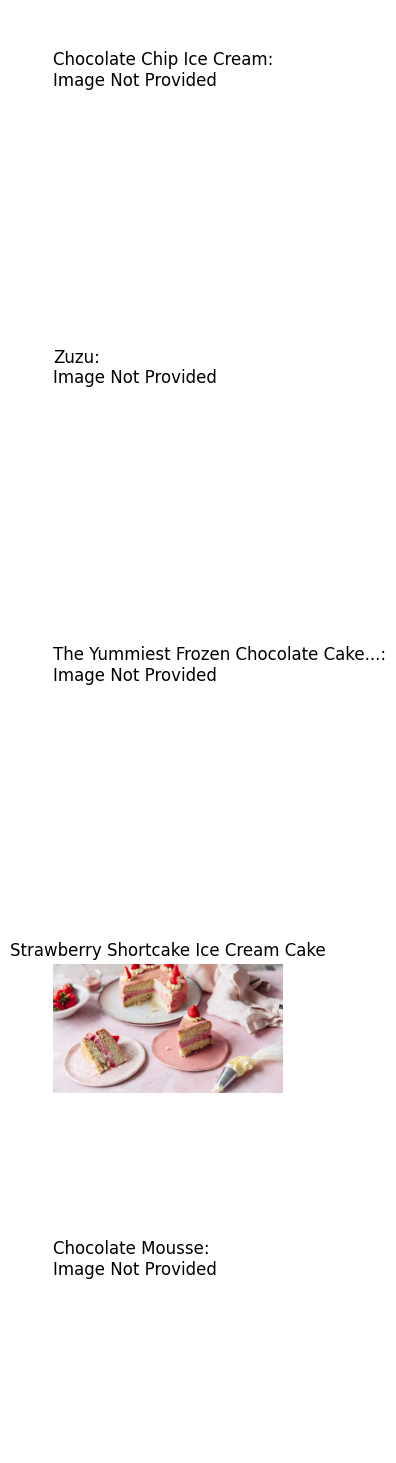

In [274]:
df = test_3_df
front_end_display(df)